In [13]:
# prerequisites
# https://github.com/lyeoni/pytorch-mnist-GAN
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [14]:
bs = 10000
n_samples = 10000
tr_split_len = n_samples
te_split_len = n_samples

# MNIST Dataset
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transform, download=False)

part_tr = torch.utils.data.random_split(train_dataset, [tr_split_len, len(train_dataset)-tr_split_len])[0]
part_te = torch.utils.data.random_split(test_dataset, [te_split_len, len(test_dataset)-te_split_len])[0]

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=part_tr, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=part_te, batch_size=bs, shuffle=False)

In [15]:
print(type(train_dataset))
print(train_dataset)

print(type(train_loader))
print(train_loader)

print(len(train_loader.dataset))

<class 'torchvision.datasets.mnist.MNIST'>
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
<class 'torch.utils.data.dataloader.DataLoader'>
1


In [16]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))
    


In [17]:
# build network
z_dim = 100
mnist_dim = train_dataset.train_data.size(1) * train_dataset.train_data.size(2)

G = Generator(g_input_dim = z_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [18]:
G

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)

In [19]:
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
)

In [20]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [ ]:
# TAKEN FROM ANOTEHR
def RD_train(x_r):
    RD.zero_grad()
    G.zero_grad()

    # My code
    latent_samples = Variable(torch.randn(batch_size, latent_dim))# SHOULD BE DOING UNIFORM (rand()) FOR TRANSFER TO DACCA!!!!
    x_f = G(latent_samples)

    sout = torch.sigmoid(RD(x_r) - RD(x_f))# where C is some discrim with LINEAR OUTPUT
    RD_loss = -torch.mean(torch.log(sout))
    
    RD_loss.backward() #retain_graph=True
    RD_optimizer.step()
        
    return  RD_loss.data.item()

# For paper recreation
def RD_G_train(x_r):
    G.zero_grad()
    RD.zero_grad()

    # My code
    latent_samples = Variable(torch.randn(batch_size, latent_dim))# SHOULD BE DOING UNIFORM (rand()) FOR TRANSFER TO DACCA!!!!
    x_f = G(latent_samples)
    
    sout = torch.sigmoid(RD(x_f) - RD(x_r))# where C is some discrim with LINEAR OUTPUT

    G_loss = -torch.mean(torch.log(sout))
    
    # gradient backprop & optimize ONLY G's parameters
    
    G_loss.backward() #retain_graph=True
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
def R_train(x):
    #=======================Train the discriminator=======================#
    R.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()



In [21]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, mnist_dim), torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = Variable(torch.randn(bs, z_dim).to(device))
    x_fake, y_fake = G(z), Variable(torch.zeros(bs, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [22]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = Variable(torch.randn(bs, z_dim).to(device))
    y = Variable(torch.ones(bs, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

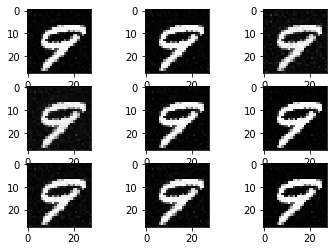

[1000/60000]: loss_d: 1.272, loss_g: 0.477


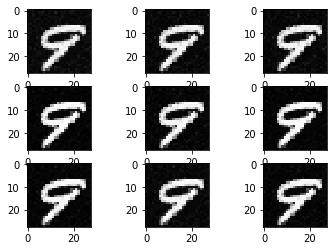

[2000/60000]: loss_d: 1.257, loss_g: 0.628


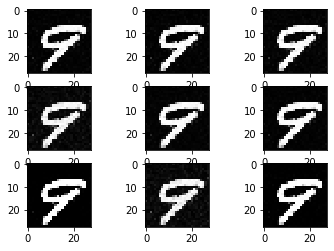

[3000/60000]: loss_d: 1.712, loss_g: 0.664


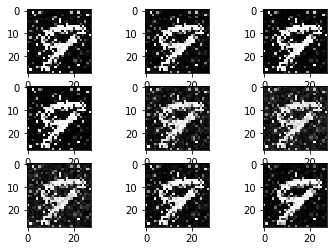

[4000/60000]: loss_d: 1.800, loss_g: 1.296


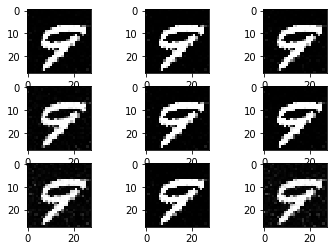

[5000/60000]: loss_d: 0.886, loss_g: 0.681


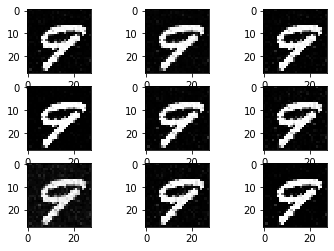

[6000/60000]: loss_d: 1.857, loss_g: 0.489


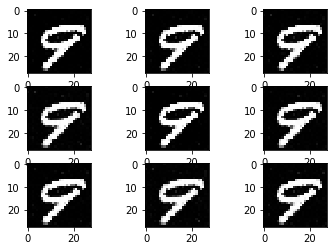

[7000/60000]: loss_d: 1.032, loss_g: 0.669


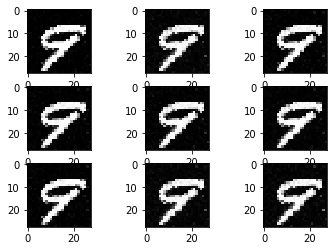

[8000/60000]: loss_d: 1.169, loss_g: 0.859


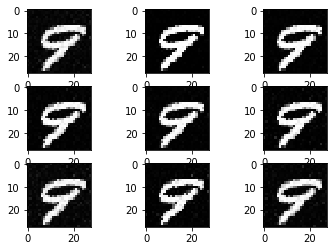

[9000/60000]: loss_d: 1.328, loss_g: 0.563


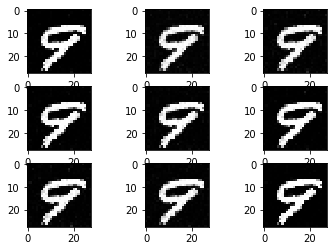

[10000/60000]: loss_d: 1.070, loss_g: 0.949


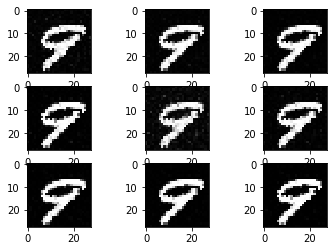

[11000/60000]: loss_d: 1.517, loss_g: 1.073


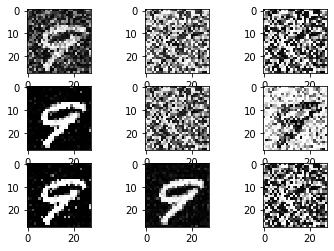

[12000/60000]: loss_d: 1.825, loss_g: 0.021


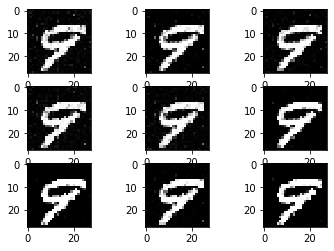

[13000/60000]: loss_d: 1.327, loss_g: 0.940


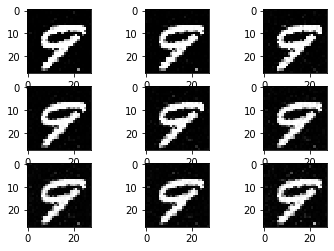

[14000/60000]: loss_d: 1.563, loss_g: 0.794


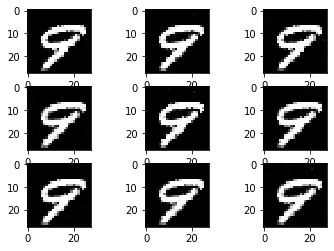

[15000/60000]: loss_d: 1.510, loss_g: 0.754


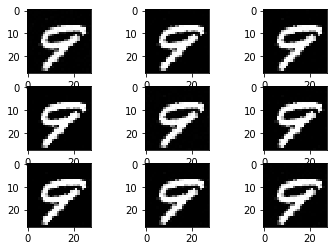

[16000/60000]: loss_d: 1.436, loss_g: 0.771


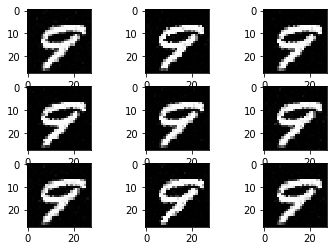

[17000/60000]: loss_d: 1.435, loss_g: 0.619


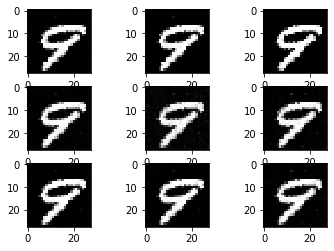

[18000/60000]: loss_d: 1.214, loss_g: 0.459


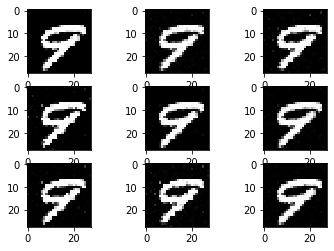

[19000/60000]: loss_d: 1.563, loss_g: 0.814


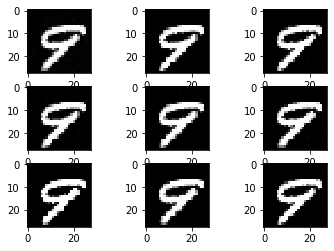

[20000/60000]: loss_d: 1.596, loss_g: 0.681


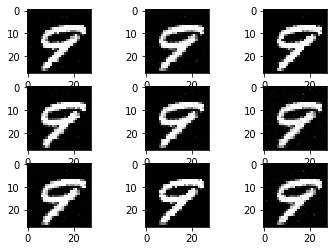

[21000/60000]: loss_d: 1.313, loss_g: 0.682


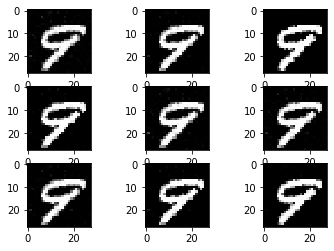

[22000/60000]: loss_d: 1.477, loss_g: 0.907


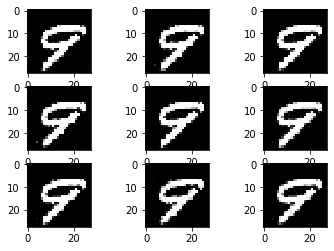

[23000/60000]: loss_d: 1.255, loss_g: 0.774


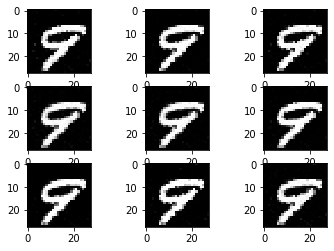

[24000/60000]: loss_d: 1.354, loss_g: 1.031


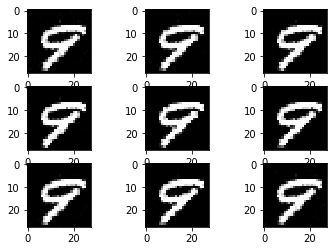

[25000/60000]: loss_d: 1.317, loss_g: 0.693


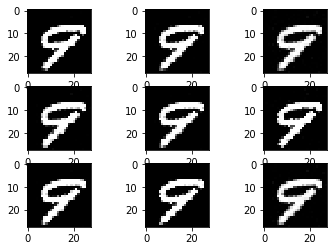

[26000/60000]: loss_d: 1.351, loss_g: 0.590


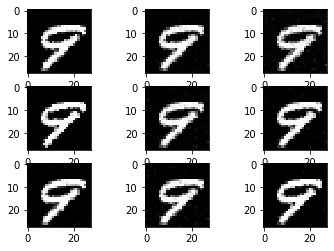

[27000/60000]: loss_d: 1.264, loss_g: 0.765


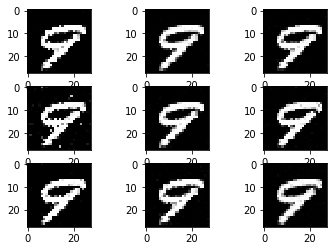

[28000/60000]: loss_d: 1.538, loss_g: 0.723


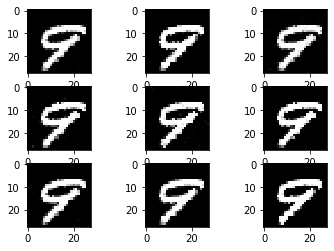

[29000/60000]: loss_d: 1.649, loss_g: 0.617


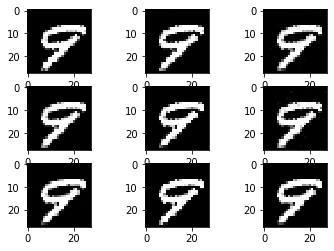

[30000/60000]: loss_d: 1.469, loss_g: 0.666


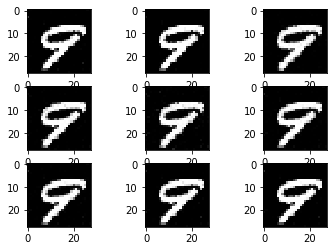

[31000/60000]: loss_d: 1.448, loss_g: 0.675


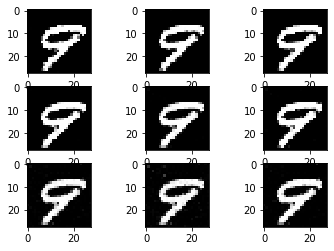

[32000/60000]: loss_d: 1.447, loss_g: 1.083


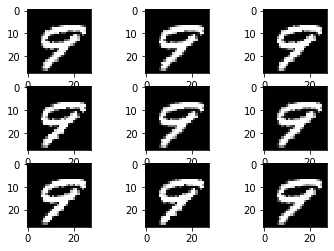

[33000/60000]: loss_d: 1.151, loss_g: 0.477


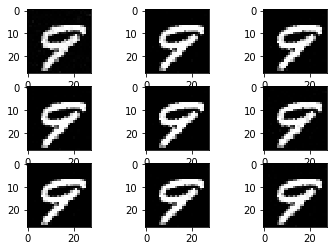

[34000/60000]: loss_d: 1.436, loss_g: 0.550


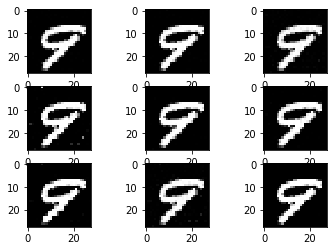

[35000/60000]: loss_d: 1.272, loss_g: 0.555


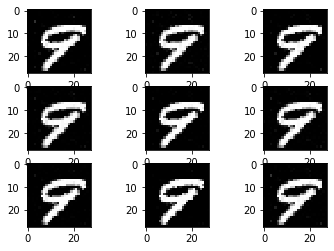

[36000/60000]: loss_d: 1.423, loss_g: 0.509


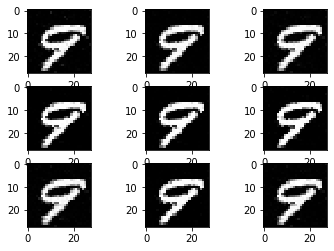

[37000/60000]: loss_d: 1.490, loss_g: 0.832


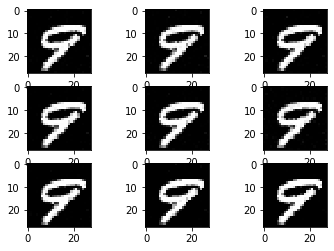

[38000/60000]: loss_d: 1.218, loss_g: 0.729


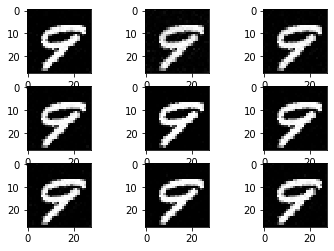

[39000/60000]: loss_d: 1.439, loss_g: 0.622


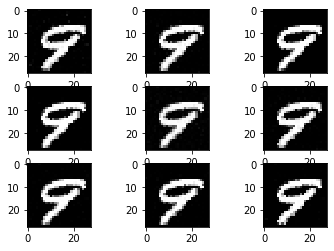

[40000/60000]: loss_d: 1.326, loss_g: 0.438


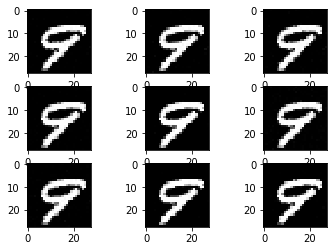

[41000/60000]: loss_d: 1.178, loss_g: 0.740


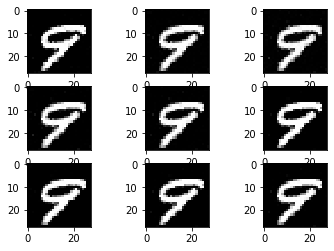

[42000/60000]: loss_d: 1.447, loss_g: 0.746


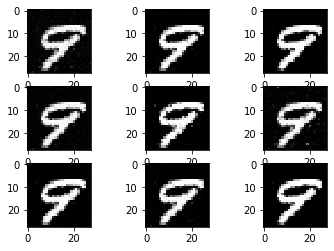

[43000/60000]: loss_d: 1.632, loss_g: 0.440


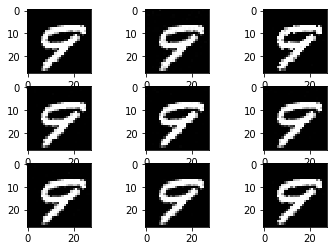

[44000/60000]: loss_d: 1.119, loss_g: 0.980


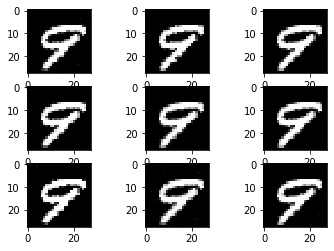

[45000/60000]: loss_d: 1.124, loss_g: 0.800


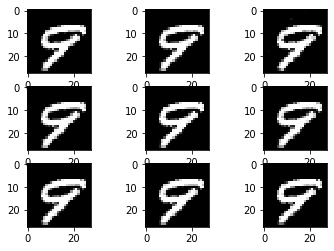

[46000/60000]: loss_d: 1.263, loss_g: 0.452


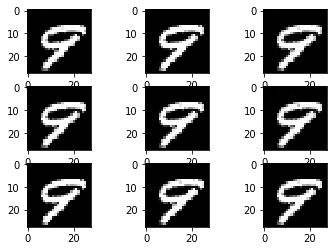

[47000/60000]: loss_d: 1.307, loss_g: 0.563


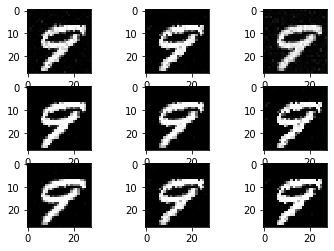

[48000/60000]: loss_d: 1.389, loss_g: 0.543


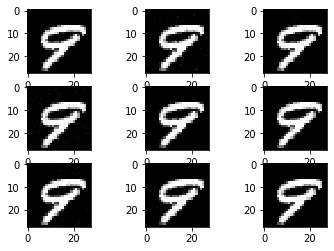

[49000/60000]: loss_d: 1.499, loss_g: 0.845


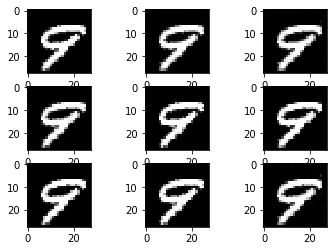

[50000/60000]: loss_d: 1.061, loss_g: 0.898


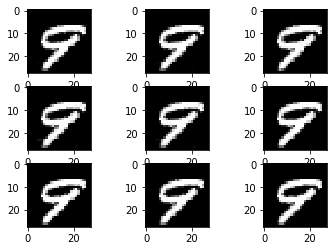

[51000/60000]: loss_d: 1.245, loss_g: 0.713


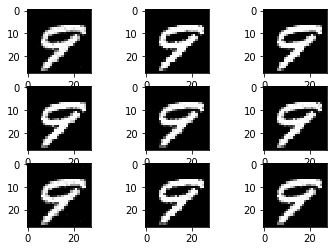

[52000/60000]: loss_d: 1.287, loss_g: 0.964


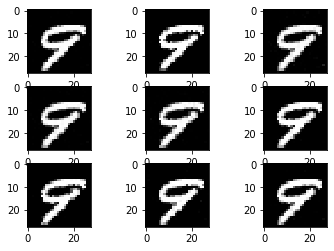

[53000/60000]: loss_d: 1.546, loss_g: 0.734


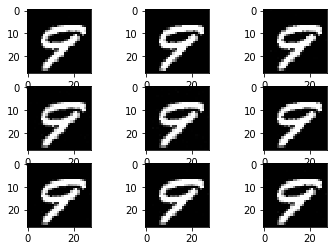

[54000/60000]: loss_d: 1.395, loss_g: 0.677


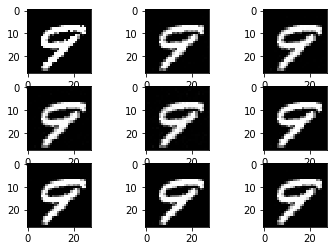

[55000/60000]: loss_d: 1.748, loss_g: 0.769


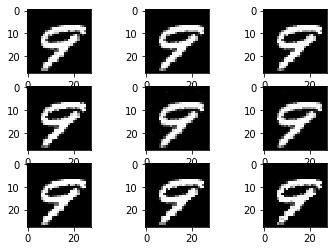

[56000/60000]: loss_d: 1.278, loss_g: 0.763


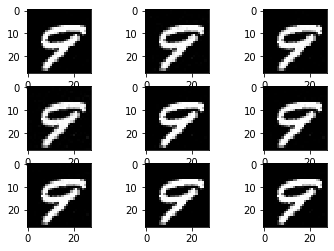

[57000/60000]: loss_d: 1.638, loss_g: 0.867


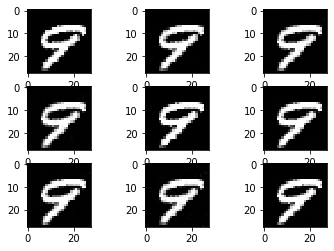

[58000/60000]: loss_d: 1.494, loss_g: 0.878


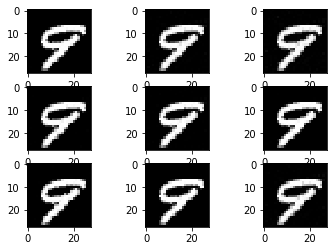

[59000/60000]: loss_d: 1.170, loss_g: 0.462


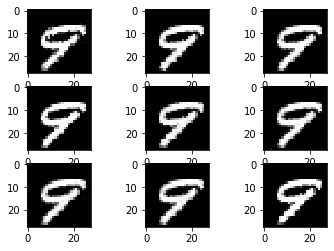

[60000/60000]: loss_d: 1.422, loss_g: 0.858


In [24]:
#n_epoch = 200
#n_epoch = 200*(60000//n_samples) #200 by 60000 is default
n_epoch = 1*(60000//n_samples) #200 by 60000 is default

print_stride = 1000

for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))
        
        
            
    if epoch % print_stride == 0:
            with torch.no_grad():
                test_z = Variable(torch.randn(9, z_dim).to(device))
                generated = G.forward(test_z).cpu().detach().numpy()

                for i in range(9):
                    plt.subplot(330 + 1 + i)
                    # plot raw pixel data
                    element = generated[i,:].reshape(28,28)
                    plt.imshow(element, cmap=plt.get_cmap('gray'))
                    #print('pen: ', pen)
                    #print('numer: ', numer)
                    #print('denom: ', denom)
                plt.show()
                print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % ((epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

In [ ]:
with torch.no_grad():
    test_z = Variable(torch.randn(bs, z_dim).to(device))
    generated = G(test_z)

    save_image(generated.view(generated.size(0), 1, 28, 28), f'./samples/sample_{n_samples}' + '.png')

In [ ]:
with torch.nograd():
    